In [174]:
import requests
import json
from time import sleep
import time
from bs4 import BeautifulSoup
from pathlib import Path
import numpy as np
import datetime
import os
import re
import glob
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.utils.project import get_project_settings
import pandas as pd
import re
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Normalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import random

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

now = str(datetime.datetime.now().year)+str('0'+str(datetime.datetime.now().month))[-2:]+str('0'+str(datetime.datetime.now().day))[-2:]


In [161]:
# Deep neural network regression

In [162]:
df = pd.read_csv('datasets/20250623_dataset_cleaned.csv')

In [163]:
df.columns

Index(['make', 'year', 'trim', 'model', 'stock_type', 'fuel_type', 'bodystyle',
       'photo_count', 'drivetrain', 'engine', 'accidents_or_damage',
       'clean_title', 'one_owner_vehicle', 'personal_use_only', 'open_recall',
       'comfort_rating', 'interior_rating', 'performance_rating',
       'value_rating', 'exterior_rating', 'reliability_rating',
       'interior_color_tone', 'exterior_color_tone', 'transmission_type',
       'mileage_clean', 'price'],
      dtype='object')

In [164]:
df.describe(include='all')

,make,year,trim,model,stock_type,fuel_type,bodystyle,photo_count,drivetrain,engine,accidents_or_damage,clean_title,one_owner_vehicle,personal_use_only,open_recall,comfort_rating,interior_rating,performance_rating,value_rating,exterior_rating,reliability_rating,interior_color_tone,exterior_color_tone,transmission_type,mileage_clean,price
count,30195,30195.000000,30195,30195,30195,30195,30195,30195.000000,30195,30195,30195,30195,30195,30195,30195,30195.000000,30195.000000,30195.000000,30195.000000,30195.000000,30195.000000,30195,30195,30195,30195.000000,30195.000000
unique,8,NaN,610,194,1,3,11,NaN,5,1197,3,3,3,3,2,NaN,NaN,NaN,NaN,NaN,NaN,7,12,6,NaN,NaN
top,nissan,NaN,sv,cr_v,used,Gasoline,suv,NaN,FWD,"2.5L I-4 DOHC, variable valve control, regular...",At least 1 accident or damage reported,Unknown,No,Yes,None,NaN,NaN,NaN,NaN,NaN,NaN,Black,Silver,Automatic,NaN,NaN
freq,8583,NaN,2644,1881,30195,29384,13822,NaN,15584,1785,15021,20314,19626,21443,25746,NaN,NaN,NaN,NaN,NaN,NaN,17736,8501,25048,NaN,NaN
mean,NaN,2015.892797,NaN,NaN,NaN,NaN,NaN,25.715118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.595294,4.531734,4.517559,4.548998,4.636370,4.664362,NaN,NaN,NaN,106413.741519,13662.552045
std,NaN,4.571910,NaN,NaN,NaN,NaN,NaN,13.519045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.234540,0.230646,0.276574,0.246551,0.220986,0.234263,NaN,NaN,NaN,49949.970101,4494.398830
min,NaN,1976.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,2013.000000,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.500000,4.400000,4.400000,4.500000,4.500000,4.600000,NaN,NaN,NaN,71535.500000,9998.000000
50%,NaN,2016.000000,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.600000,4.600000,4.600000,4.600000,4.700000,4.700000,NaN,NaN,NaN,101641.000000,14275.000000
75%,NaN,2019.000000,NaN,NaN,NaN,NaN,NaN,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.800000,4.700000,4.700000,4.700000,4.800000,4.800000,NaN,NaN,NaN,134850.000000,17500.000000


In [165]:
# Define vocab/embedding sizes
num_makes = len(df['make'].unique())
num_stock_types = len(df['stock_type'].unique())
num_fuel_types = len(df['fuel_type'].unique())
num_bodystyles = len(df['bodystyle'].unique())
num_drivetrains = len(df['drivetrain'].unique())
num_accidents_or_damages = len(df['accidents_or_damage'].unique())
num_clean_titles = len(df['clean_title'].unique())
num_one_owner_vehicles = len(df['one_owner_vehicle'].unique())
num_personal_use_onlys = len(df['personal_use_only'].unique())
num_open_recalls = len(df['open_recall'].unique())
num_interior_color_tones = len(df['interior_color_tone'].unique())
num_exterior_color_tones = len(df['exterior_color_tone'].unique())
num_transmission_types = len(df['transmission_type'].unique())

num_trim_tokens = 1000
num_model_tokens = 1000
num_engine_tokens = 1000

embedding_dim = 8

# Input layers
############### Categorical
# make
# stock_type
# fuel_type
# bodystyle
# drivetrain
# accidents_or_damage
# clean_title
# one_owner_vehicle
# personal_use_only
# open_recall
# interior_color_tone
# exterior_color_tone
# transmission_type
make_input = Input(shape=(1,), name='make_input')      # integer encoded
stock_type_input = Input(shape=(1,), name='stock_type_input')      # integer encoded
fuel_type_input = Input(shape=(1,), name='fuel_type_input')      # integer encoded
bodystyle_input = Input(shape=(1,), name='bodystyle_input')      # integer encoded
drivetrain_input = Input(shape=(1,), name='drivetrain_input')      # integer encoded
accidents_or_damage_input = Input(shape=(1,), name='accidents_or_damage_input')      # integer encoded
clean_title_input = Input(shape=(1,), name='clean_title_input')      # integer encoded
one_owner_vehicle_input = Input(shape=(1,), name='one_owner_vehicle_input')      # integer encoded
personal_use_only_input = Input(shape=(1,), name='personal_use_only_input')      # integer encoded
open_recall_input = Input(shape=(1,), name='open_recall_input')      # integer encoded
interior_color_tone_input = Input(shape=(1,), name='interior_color_tone_input')      # integer encoded
exterior_color_tone_input = Input(shape=(1,), name='exterior_color_tone_input')      # integer encoded
transmission_type_input = Input(shape=(1,), name='transmission_type_input')      # integer encoded

############### Word embedding
# trim
# model
# engine
trim_input = Input(shape=(5,), name='trim_input') # tokenized sequence
model_input = Input(shape=(5,), name='model_input') # tokenized sequence
engine_input = Input(shape=(5,), name='engine_input') # tokenized sequence

############### Continuous
# year
# photo_count
# comfort_rating
# interior_rating
# performance_rating
# value_rating
# exterior_rating
# reliability_rating
# mileage_clean
year_input = Input(shape=(1,), name='year_input')
photo_count_input = Input(shape=(1,), name='photo_count_input')
comfort_rating_input = Input(shape=(1,), name='comfort_rating_input')
interior_rating_input = Input(shape=(1,), name='interior_rating_input')
performance_rating_input = Input(shape=(1,), name='performance_rating_input')
value_rating_input = Input(shape=(1,), name='value_rating_input')
exterior_rating_input = Input(shape=(1,), name='exterior_rating_input')
reliability_rating_input = Input(shape=(1,), name='reliability_rating_input')
mileage_input = Input(shape=(1,), name='mileage_input')

# Embedding layers
make_emb = Flatten()(Embedding(num_makes, embedding_dim)(make_input))
stock_type_emb = Flatten()(Embedding(num_stock_types, embedding_dim)(stock_type_input))
fuel_type_emb = Flatten()(Embedding(num_fuel_types, embedding_dim)(fuel_type_input))
bodystyle_emb = Flatten()(Embedding(num_bodystyles, embedding_dim)(bodystyle_input))
drivetrain_emb = Flatten()(Embedding(num_drivetrains, embedding_dim)(drivetrain_input))
accidents_or_damage_emb = Flatten()(Embedding(num_accidents_or_damages, embedding_dim)(accidents_or_damage_input))
clean_title_emb = Flatten()(Embedding(num_clean_titles, embedding_dim)(clean_title_input))
one_owner_vehicle_emb = Flatten()(Embedding(num_one_owner_vehicles, embedding_dim)(one_owner_vehicle_input))
personal_use_only_emb = Flatten()(Embedding(num_personal_use_onlys, embedding_dim)(personal_use_only_input))
open_recall_emb = Flatten()(Embedding(num_open_recalls, embedding_dim)(open_recall_input))
interior_color_tone_emb = Flatten()(Embedding(num_interior_color_tones, embedding_dim)(interior_color_tone_input))
exterior_color_tone_emb = Flatten()(Embedding(num_exterior_color_tones, embedding_dim)(exterior_color_tone_input))
transmission_type_emb = Flatten()(Embedding(num_transmission_types, embedding_dim)(transmission_type_input))
trim_emb = Flatten()(Embedding(num_trim_tokens, embedding_dim)(trim_input))
model_emb = Flatten()(Embedding(num_model_tokens, embedding_dim)(model_input))
engine_emb = Flatten()(Embedding(num_engine_tokens, embedding_dim)(engine_input))

# Normalize continuous variables
norm_year_layer = Normalization()
norm_year = norm_year_layer(year_input)
norm_photo_count_layer = Normalization()
norm_photo_count = norm_photo_count_layer(photo_count_input)
norm_comfort_rating_layer = Normalization()
norm_comfort_rating = norm_comfort_rating_layer(comfort_rating_input)
norm_interior_rating_layer = Normalization()
norm_interior_rating = norm_interior_rating_layer(interior_rating_input)
norm_performance_rating_layer = Normalization()
norm_performance_rating = norm_performance_rating_layer(performance_rating_input)
norm_value_rating_layer = Normalization()
norm_value_rating = norm_value_rating_layer(value_rating_input)
norm_exterior_rating_layer = Normalization()
norm_exterior_rating = norm_exterior_rating_layer(exterior_rating_input)
norm_reliability_rating_layer = Normalization()
norm_reliability_rating = norm_reliability_rating_layer(reliability_rating_input)
norm_mileage_layer = Normalization()
norm_mileage = norm_mileage_layer(mileage_input)

# Concatenate features
x = Concatenate()([make_emb,stock_type_emb,fuel_type_emb,bodystyle_emb,
                   drivetrain_emb,accidents_or_damage_emb,clean_title_emb,
                   one_owner_vehicle_emb,personal_use_only_emb,open_recall_emb,
                   interior_color_tone_emb,exterior_color_tone_emb,transmission_type_emb,
                   trim_emb,model_emb,engine_emb,norm_year,norm_photo_count,
                   norm_comfort_rating,norm_interior_rating,norm_performance_rating,
                   norm_value_rating,norm_exterior_rating,norm_reliability_rating,norm_mileage])

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

# Build and compile model
model = Model(inputs=[
    make_input,stock_type_input,fuel_type_input,bodystyle_input,drivetrain_input,
    accidents_or_damage_input,clean_title_input,one_owner_vehicle_input,
    personal_use_only_input,open_recall_input,interior_color_tone_input,
    exterior_color_tone_input,transmission_type_input,trim_input,model_input,
    engine_input,year_input,photo_count_input,comfort_rating_input,interior_rating_input,
    performance_rating_input,value_rating_input,exterior_rating_input,reliability_rating_input,
    mileage_input,], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [166]:
make_le = LabelEncoder()
stock_type_le = LabelEncoder()
fuel_type_le = LabelEncoder()
bodystyle_le = LabelEncoder()
drivetrain_le = LabelEncoder()
accidents_or_damage_le = LabelEncoder()
clean_title_le = LabelEncoder()
one_owner_vehicle_le = LabelEncoder()
personal_use_only_le = LabelEncoder()
open_recall_le = LabelEncoder()
interior_color_tone_le = LabelEncoder()
exterior_color_tone_le = LabelEncoder()
transmission_type_le = LabelEncoder()

df['make_encoded'] = make_le.fit_transform(df['make'])
df['stock_type_encoded'] = stock_type_le.fit_transform(df['stock_type'])
df['fuel_type_encoded'] = fuel_type_le.fit_transform(df['fuel_type'])
df['bodystyle_encoded'] = bodystyle_le.fit_transform(df['bodystyle'])
df['drivetrain_encoded'] = drivetrain_le.fit_transform(df['drivetrain'])
df['accidents_or_damage_encoded'] = accidents_or_damage_le.fit_transform(df['accidents_or_damage'])
df['clean_title_encoded'] = clean_title_le.fit_transform(df['clean_title'])
df['one_owner_vehicle_encoded'] = one_owner_vehicle_le.fit_transform(df['one_owner_vehicle'])
df['personal_use_only_encoded'] = personal_use_only_le.fit_transform(df['personal_use_only'])
df['open_recall_encoded'] = open_recall_le.fit_transform(df['open_recall'])
df['interior_color_tone_encoded'] = interior_color_tone_le.fit_transform(df['interior_color_tone'])
df['exterior_color_tone_encoded'] = exterior_color_tone_le.fit_transform(df['exterior_color_tone'])
df['transmission_type_encoded'] = transmission_type_le.fit_transform(df['transmission_type'])

# Tokenize and pad 'trim' text
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['trim'])
trim_seq = tokenizer.texts_to_sequences(df['trim'])
trim_padded = pad_sequences(trim_seq, maxlen=5, padding='post')

# Tokenize and pad 'model' text
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['model'])
model_seq = tokenizer.texts_to_sequences(df['model'])
model_padded = pad_sequences(model_seq, maxlen=5, padding='post')

# Tokenize and pad 'engine' text
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['engine'])
engine_seq = tokenizer.texts_to_sequences(df['engine'])
engine_padded = pad_sequences(engine_seq, maxlen=5, padding='post')


In [167]:
print(make_le.classes_)
print(stock_type_le.classes_)
print(fuel_type_le.classes_)
print(bodystyle_le.classes_)
print(drivetrain_le.classes_)
print(accidents_or_damage_le.classes_)
print(clean_title_le.classes_)
print(one_owner_vehicle_le.classes_)
print(personal_use_only_le.classes_)
print(open_recall_le.classes_)
print(interior_color_tone_le.classes_)
print(exterior_color_tone_le.classes_)
print(transmission_type_le.classes_)

['honda' 'hyundai' 'kia' 'mazda' 'mitsubishi' 'nissan' 'subaru' 'toyota']
['used']
['Electric' 'Gasoline' 'Hybrid']
['Unknown' 'cargo_van' 'convertible' 'coupe' 'hatchback' 'minivan'
 'passenger_van' 'sedan' 'suv' 'truck' 'wagon']
['4WD' 'AWD' 'FWD' 'RWD' 'Unknown']
['At least 1 accident or damage reported' 'None reported' 'Unknown']
['No' 'Unknown' 'Yes']
['No' 'Unknown' 'Yes']
['No' 'Unknown' 'Yes']
['At least 1 open recall reported' 'None']
['Black' 'Blue' 'Brown_Earth' 'Gray' 'Neutral' 'Other' 'Red_Warm']
['Black' 'Blue' 'Brown' 'Gray' 'Green' 'Orange_Yellow' 'Other' 'Purple'
 'Red' 'Silver' 'Teal' 'White']
['Automatic' 'CVT' 'Manual' 'Not Specified' 'Other' 'Variable']


In [168]:
X_make = df['make_encoded'].values.reshape(-1, 1)
X_stock_type = df['stock_type_encoded'].values.reshape(-1, 1)
X_fuel_type = df['fuel_type_encoded'].values.reshape(-1, 1)
X_bodystyle = df['bodystyle_encoded'].values.reshape(-1, 1)
X_drivetrain = df['drivetrain_encoded'].values.reshape(-1, 1)
X_accidents_or_damage = df['accidents_or_damage_encoded'].values.reshape(-1, 1)
X_clean_title = df['clean_title_encoded'].values.reshape(-1, 1)
X_one_owner_vehicle = df['one_owner_vehicle_encoded'].values.reshape(-1, 1)
X_personal_use_only = df['personal_use_only_encoded'].values.reshape(-1, 1)
X_open_recall = df['open_recall_encoded'].values.reshape(-1, 1)
X_interior_color_tone = df['interior_color_tone_encoded'].values.reshape(-1, 1)
X_exterior_color_tone = df['exterior_color_tone_encoded'].values.reshape(-1, 1)
X_transmission_type = df['transmission_type_encoded'].values.reshape(-1, 1)

X_trim = trim_padded  # shape (N, 5)
X_model = model_padded  # shape (N, 5)
X_engine = engine_padded  # shape (N, 5)

X_year = df['year'].values.reshape(-1, 1)
X_photo_count = df['photo_count'].values.reshape(-1, 1)
X_comfort_rating = df['comfort_rating'].values.reshape(-1, 1)
X_interior_rating = df['interior_rating'].values.reshape(-1, 1)
X_performance_rating = df['performance_rating'].values.reshape(-1, 1)
X_value_rating = df['value_rating'].values.reshape(-1, 1)
X_exterior_rating = df['exterior_rating'].values.reshape(-1, 1)
X_reliability_rating = df['reliability_rating'].values.reshape(-1, 1)
X_mileage = df['mileage_clean'].values.reshape(-1, 1)

y = df['price'].values.reshape(-1, 1)

############################################################################################################

# Test data

X_make_test = X_make[-2000:]
X_stock_type_test = X_stock_type[-2000:]
X_fuel_type_test = X_fuel_type[-2000:]
X_bodystyle_test = X_bodystyle[-2000:]
X_drivetrain_test = X_drivetrain[-2000:]
X_accidents_or_damage_test = X_accidents_or_damage[-2000:]
X_clean_title_test = X_clean_title[-2000:]
X_one_owner_vehicle_test = X_one_owner_vehicle[-2000:]
X_personal_use_only_test = X_personal_use_only[-2000:]
X_open_recall_test = X_open_recall[-2000:]
X_interior_color_tone_test = X_interior_color_tone[-2000:]
X_exterior_color_tone_test = X_exterior_color_tone[-2000:]
X_transmission_type_test = X_transmission_type[-2000:]

X_trim_test = X_trim[-2000:]
X_model_test = X_model[-2000:]
X_engine_test = X_engine[-2000:]

X_year_test = X_year[-2000:]
X_photo_count_test = X_photo_count[-2000:]
X_comfort_rating_test = X_comfort_rating[-2000:]
X_interior_rating_test = X_interior_rating[-2000:]
X_performance_rating_test = X_performance_rating[-2000:]
X_value_rating_test = X_value_rating[-2000:]
X_exterior_rating_test = X_exterior_rating[-2000:]
X_reliability_rating_test = X_reliability_rating[-2000:]
X_mileage_test = X_mileage[-2000:]

y_test = y[-2000:]

# Train data

X_make = X_make[:-2000]
X_stock_type = X_stock_type[:-2000]
X_fuel_type = X_fuel_type[:-2000]
X_bodystyle = X_bodystyle[:df.shape[0]-2000]
X_drivetrain = X_drivetrain[:df.shape[0]-2000]
X_accidents_or_damage = X_accidents_or_damage[:df.shape[0]-2000]
X_clean_title = X_clean_title[:df.shape[0]-2000]
X_one_owner_vehicle = X_one_owner_vehicle[:df.shape[0]-2000]
X_personal_use_only = X_personal_use_only[:df.shape[0]-2000]
X_open_recall = X_open_recall[:df.shape[0]-2000]
X_interior_color_tone = X_interior_color_tone[:df.shape[0]-2000]
X_exterior_color_tone = X_exterior_color_tone[:df.shape[0]-2000]
X_transmission_type = X_transmission_type[:df.shape[0]-2000]

X_trim = X_trim[:df.shape[0]-2000]
X_model = X_model[:df.shape[0]-2000]
X_engine = X_engine[:df.shape[0]-2000]

X_year = X_year[:df.shape[0]-2000]
X_photo_count = X_photo_count[:df.shape[0]-2000]
X_comfort_rating = X_comfort_rating[:df.shape[0]-2000]
X_interior_rating = X_interior_rating[:df.shape[0]-2000]
X_performance_rating = X_performance_rating[:df.shape[0]-2000]
X_value_rating = X_value_rating[:df.shape[0]-2000]
X_exterior_rating = X_exterior_rating[:df.shape[0]-2000]
X_reliability_rating = X_reliability_rating[:df.shape[0]-2000]
X_mileage = X_mileage[:df.shape[0]-2000]

y = y[:df.shape[0]-2000]

############################################################################################################

# Train-test split
(X_make_train, X_make_val,
 X_stock_type_train, X_stock_type_val,
 X_fuel_type_train, X_fuel_type_val,
 X_bodystyle_train, X_bodystyle_val,
 X_drivetrain_train, X_drivetrain_val,
 X_accidents_or_damage_train, X_accidents_or_damage_val,
 X_clean_title_train, X_clean_title_val,
 X_one_owner_vehicle_train, X_one_owner_vehicle_val,
 X_personal_use_only_train, X_personal_use_only_val,
 X_open_recall_train, X_open_recall_val,
 X_interior_color_tone_train, X_interior_color_tone_val,
 X_exterior_color_tone_train, X_exterior_color_tone_val,
 X_transmission_type_train, X_transmission_type_val,
 X_trim_train, X_trim_val,
 X_model_train, X_model_val,
 X_engine_train, X_engine_val,
 X_year_train, X_year_val,
 X_photo_count_train, X_photo_count_val,
 X_comfort_rating_train, X_comfort_rating_val,
 X_interior_rating_train, X_interior_rating_val,
 X_performance_rating_train, X_performance_rating_val,
 X_value_rating_train, X_value_rating_val,
 X_exterior_rating_train, X_exterior_rating_val,
 X_reliability_rating_train, X_reliability_rating_val,
 X_mileage_train, X_mileage_val,
 y_train, y_val) = train_test_split(
    X_make,X_stock_type,X_fuel_type,X_bodystyle,
    X_drivetrain,X_accidents_or_damage,X_clean_title,X_one_owner_vehicle,
    X_personal_use_only,X_open_recall,X_interior_color_tone,X_exterior_color_tone,
    X_transmission_type,X_trim,X_model,X_engine,X_year,X_photo_count,X_comfort_rating,
    X_interior_rating,X_performance_rating,X_value_rating,X_exterior_rating,
    X_reliability_rating,X_mileage, y, test_size=0.2, random_state=2)

In [169]:
history = model.fit(
    x=[X_make_train,X_stock_type_train,X_fuel_type_train,X_bodystyle_train,
       X_drivetrain_train,X_accidents_or_damage_train,X_clean_title_train,
       X_one_owner_vehicle_train,X_personal_use_only_train,X_open_recall_train,
       X_interior_color_tone_train,X_exterior_color_tone_train,X_transmission_type_train,
       X_trim_train,X_model_train,X_engine_train,
       X_year_train,X_photo_count_train,
       X_comfort_rating_train,X_interior_rating_train,X_performance_rating_train,
       X_value_rating_train,X_exterior_rating_train,X_reliability_rating_train,X_mileage_train],
    y=y_train,
    validation_data=([X_make_val,X_stock_type_val,X_fuel_type_val,X_bodystyle_val,
                      X_drivetrain_val,X_accidents_or_damage_val,X_clean_title_val,
                      X_one_owner_vehicle_val,X_personal_use_only_val,X_open_recall_val,
                      X_interior_color_tone_val,X_exterior_color_tone_val,X_transmission_type_val,
                      X_trim_val,X_model_val,X_engine_val,
                      X_year_val,X_photo_count_val,
                      X_comfort_rating_val,X_interior_rating_val,X_performance_rating_val,
                      X_value_rating_val,X_exterior_rating_val,X_reliability_rating_val,X_mileage_val], y_val),
    epochs=30,
    batch_size=32,
)


Epoch 1/30
705/705 [==============================] - 4s 3ms/step - loss: 25465344.0000 - mae: 3844.3438 - val_loss: 11659026.0000 - val_mae: 2741.5947
Epoch 2/30
705/705 [==============================] - 2s 3ms/step - loss: 11520420.0000 - mae: 2693.8254 - val_loss: 10950335.0000 - val_mae: 2586.6785
Epoch 3/30
705/705 [==============================] - 2s 3ms/step - loss: 9763054.0000 - mae: 2454.6401 - val_loss: 7933610.5000 - val_mae: 2225.8545
Epoch 4/30
705/705 [==============================] - 2s 3ms/step - loss: 8076552.0000 - mae: 2208.3867 - val_loss: 7826623.5000 - val_mae: 2207.2051
Epoch 5/30
705/705 [==============================] - 2s 3ms/step - loss: 7637280.0000 - mae: 2142.7224 - val_loss: 8091762.5000 - val_mae: 2239.0435
Epoch 6/30
705/705 [==============================] - 2s 3ms/step - loss: 7165662.0000 - mae: 2075.0073 - val_loss: 6486687.0000 - val_mae: 1966.3628
Epoch 7/30
705/705 [==============================] - 2s 3ms/step - loss: 6820352.0000 - mae: 20

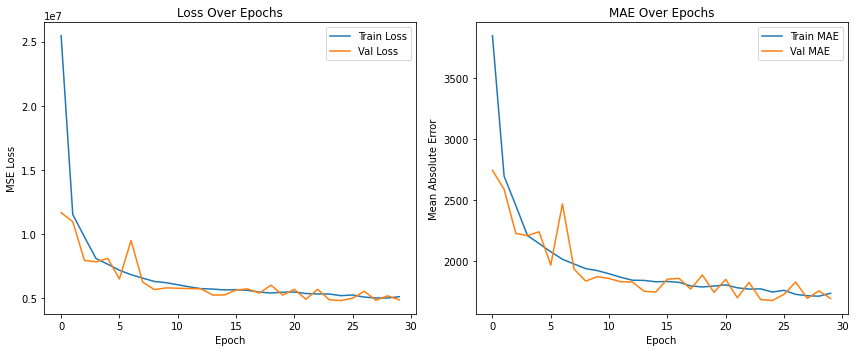

In [170]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [171]:
model.save('models/used_car_model.h5')

In [172]:
y_pred = model.predict([X_make_test,X_stock_type_test,X_fuel_type_test,X_bodystyle_test,
       X_drivetrain_test,X_accidents_or_damage_test,X_clean_title_test,
       X_one_owner_vehicle_test,X_personal_use_only_test,X_open_recall_test,
       X_interior_color_tone_test,X_exterior_color_tone_test,X_transmission_type_test,
       X_trim_test,X_model_test,X_engine_test,
       X_year_test,X_photo_count_test,
       X_comfort_rating_test,X_interior_rating_test,X_performance_rating_test,
       X_value_rating_test,X_exterior_rating_test,X_reliability_rating_test,X_mileage_test])

63/63 [==============================] - 0s 2ms/step


In [175]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

MAE: 1681.46, RMSE: 2197.45, R²: 0.76
